In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import hyperopt
from hyperopt import hp, fmin, tpe, Trials, partial
from hyperopt.early_stop import no_progress_loss

import warnings
warnings.filterwarnings('ignore')

# AI Essays

# Word2Vec

In [103]:
w2v_embeds = np.load('ai_word2vec_embeddings.npy')
labels = np.load('ai_labels.npy')

In [104]:
w2v_X_train, w2v_X_test, y_train, y_test = train_test_split(w2v_embeds, labels, test_size=0.2, random_state=247)

## Logistic Regression

In [6]:
lg = LogisticRegression()
lg.fit(w2v_X_train, y_train)

LogisticRegression()

In [7]:
lg_acc = lg.score(w2v_X_test, y_test)
lg_auc = roc_auc_score(y_test, lg.predict_proba(w2v_X_test)[:,1])

In [8]:
lg_acc, lg_auc

(0.9809572825527535, 0.9965992736122031)

## Random Forest

In [9]:
rf = RandomForestClassifier()
rf.fit(w2v_X_train, y_train)

RandomForestClassifier()

In [10]:
rf_acc = rf.score(w2v_X_test, y_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(w2v_X_test)[:,1])

In [11]:
rf_acc, rf_auc

(0.981986618630983, 0.996556526880151)

## XGBoost

### Baseline

In [105]:
w2v_X_train_xgb = xgb.DMatrix(w2v_X_train, y_train)
w2v_X_test_xgb = xgb.DMatrix(w2v_X_test, y_test)

In [22]:
params = {"objective": "binary:logistic"}
reg = xgb.train(params, w2v_X_train_xgb, num_boost_round=100)

In [24]:
xgb_base_acc = np.mean(y_test == np.where(reg.predict(w2v_X_test_xgb)>0.5, 1, 0))
xgb_base_auc = roc_auc_score(y_test, reg.predict(w2v_X_test_xgb))

In [25]:
xgb_base_acc, xgb_base_auc

(0.9876479670612455, 0.9984654107182064)

### Tuning

In [91]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":params["booster"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"objective":"binary:logistic"
                    ,"nthread":14
                    ,"verbosity":0}
    result = xgb.cv(params, w2v_X_train_xgb, seed=247, metrics=("error")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

In [95]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",50,200,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"booster":hp.choice("booster",["gbtree","dart"])
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.3,1,0.1)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.1,1,0.1)
                     ,"gamma":hp.quniform("gamma",0,10,0.5)
                     ,"lambda":hp.quniform("lambda",0,10,0.5)
                     ,"subsample":hp.quniform("subsample",0.1,1,0.1)
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.1)
                    }

In [96]:
def param_hyperopt(max_evals=100):
    
    trials = Trials()
    
    early_stop_fn = no_progress_loss(10)
    
    params_best = fmin(hyperopt_objective
                       ,space = param_grid_simple
                       ,algo = tpe.suggest
                       ,max_evals = max_evals
                       ,verbose=True
                       ,trials = trials
                       ,early_stop_fn = early_stop_fn
                      )
    
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [97]:
params_best, trials = param_hyperopt(30)

[14:00:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[14:00:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[14:00:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[14:01:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[14:01:22] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[14:01:22] WARNING: /Users/runner/work/xgboost/xgboost/

In [108]:
best_params = {'booster': 'gbtree', 
               'colsample_bynode': 0.2, 
               'colsample_bytree': 0.7, 
               'eta': 0.1, 
               'gamma': 0.2, 
               'lambda': 8.5,
               'rate_drop': 0.7, 
               'subsample': 1.0,
               "objective":"binary:logistic"
              } 

In [112]:
tuned_reg = xgb.train(best_params, w2v_X_train_xgb, num_boost_round=180)

[14:22:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "rate_drop" } are not used.



In [113]:
xgb_tuned_acc = np.mean(y_test == np.where(tuned_reg.predict(w2v_X_test_xgb)>0.5, 1, 0))
xgb_tuned_auc = roc_auc_score(y_test, tuned_reg.predict(w2v_X_test_xgb))

In [114]:
xgb_tuned_acc, xgb_tuned_auc

(0.9888488591525133, 0.9985585090528624)

## Visualization

Text(0.5, 1.0, 'Visualization of Word2Vec embeddings')

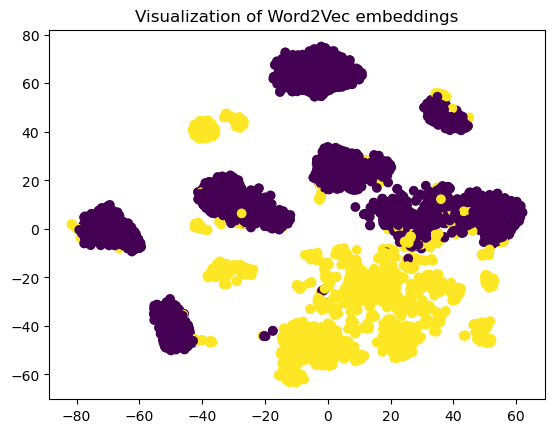

In [41]:
true_indices = np.load('visual_ai.npy')
emb_type = 'Word2Vec'
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(w2v_embeds[true_indices])
plt.scatter(*tsne_emb.T, c=labels[true_indices])
plt.title(f'Visualization of {emb_type} embeddings')

# GloVe

In [115]:
glove_embeds = np.load('glove_ai.npy')

In [116]:
glove_X_train, glove_X_test, y_train, y_test = train_test_split(glove_embeds, labels, test_size=0.2, random_state=247)

## Logistic Regression

In [117]:
lg = LogisticRegression()
lg.fit(glove_embeds, labels)

LogisticRegression()

In [118]:
lg.score(glove_embeds, labels)

0.960336249785555

## Random Forest

In [119]:
rf = RandomForestClassifier()
rf.fit(glove_X_train, y_train)

RandomForestClassifier()

In [120]:
rf_acc = rf.score(glove_X_test, y_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(glove_X_test)[:,1])

In [121]:
rf_acc, rf_auc

(0.9723794819008407, 0.99552367506596)

## XGBoost

### Baseline

In [122]:
glove_X_train_xgb = xgb.DMatrix(glove_X_train, y_train)
glove_X_test_xgb = xgb.DMatrix(glove_X_test, y_test)

In [123]:
params = {"objective": "binary:logistic"}
reg = xgb.train(params, glove_X_train_xgb, num_boost_round=100)

In [124]:
xgb_base_acc = np.mean(y_test == np.where(reg.predict(glove_X_test_xgb)>0.5, 1, 0))
xgb_base_auc = roc_auc_score(y_test, reg.predict(glove_X_test_xgb))

In [125]:
xgb_base_acc, xgb_base_auc

(0.980614170526677, 0.9975144339216477)

### Tuning

In [126]:
def hyperopt_objective(params):
    paramsforxgb = {"eta":params["eta"]
                    ,"booster":params["booster"]
                    ,"colsample_bytree":params["colsample_bytree"]
                    ,"colsample_bynode":params["colsample_bynode"]
                    ,"gamma":params["gamma"]
                    ,"lambda":params["lambda"]
                    ,"subsample":params["subsample"]
                    ,"rate_drop":params["rate_drop"]
                    ,"objective":"binary:logistic"
                    ,"nthread":14
                    ,"verbosity":0}
    result = xgb.cv(params, glove_X_train_xgb, seed=247, metrics=("error")
                    ,num_boost_round=int(params["num_boost_round"]))
    return result.iloc[-1,2]

In [127]:
param_grid_simple = {'num_boost_round': hp.quniform("num_boost_round",50,200,10)
                     ,"eta": hp.quniform("eta",0.05,2.05,0.05)
                     ,"booster":hp.choice("booster",["gbtree","dart"])
                     ,"colsample_bytree":hp.quniform("colsample_bytree",0.3,1,0.1)
                     ,"colsample_bynode":hp.quniform("colsample_bynode",0.1,1,0.1)
                     ,"gamma":hp.quniform("gamma",0,10,0.5)
                     ,"lambda":hp.quniform("lambda",0,10,0.5)
                     ,"subsample":hp.quniform("subsample",0.1,1,0.1)
                     ,"rate_drop":hp.quniform("rate_drop",0.1,1,0.1)
                    }

In [128]:
def param_hyperopt(max_evals=100):
    
    trials = Trials()
    
    early_stop_fn = no_progress_loss(10)
    
    params_best = fmin(hyperopt_objective
                       ,space = param_grid_simple
                       ,algo = tpe.suggest
                       ,max_evals = max_evals
                       ,verbose=True
                       ,trials = trials
                       ,early_stop_fn = early_stop_fn
                      )
    
    print("\n","\n","best params: ", params_best,
          "\n")
    return params_best, trials

In [129]:
params_best, trials = param_hyperopt(30)

[22:30:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

[22:30:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

[22:30:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

[22:30:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

[22:30:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are n

[22:41:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

[22:41:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

[22:41:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round", "rate_drop" } are not used.

[22:41:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[22:41:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[22:41:33] WARNI

In [130]:
best_params = {'booster': 'gbtree', 
               'colsample_bynode': 0.3, 
               'colsample_bytree': 0.4, 
               'eta': 0.05, 
               'gamma': 1.5, 
               'lambda': 6.5,
               'rate_drop': 0.5, 
               'subsample': 0.3,
               "objective":"binary:logistic"
              } 

In [134]:
tuned_reg = xgb.train(best_params, glove_X_train_xgb, num_boost_round=160)

[23:03:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "rate_drop" } are not used.



In [135]:
xgb_tuned_acc = np.mean(y_test == np.where(tuned_reg.predict(glove_X_test_xgb)>0.5, 1, 0))
xgb_tuned_auc = roc_auc_score(y_test, tuned_reg.predict(glove_X_test_xgb))

In [136]:
xgb_tuned_acc, xgb_tuned_auc

(0.9776977183050266, 0.9973308130955871)

## Visualization

Text(0.5, 1.0, 'Visualization of GloVe embeddings')

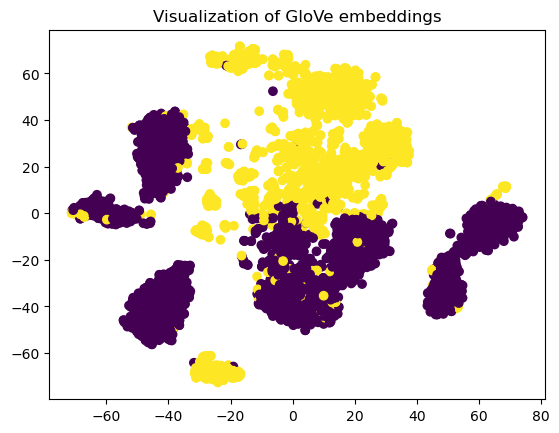

In [137]:
true_indices = np.load('visual_ai.npy')
emb_type = 'GloVe'
tsne = TSNE(n_components=2)
tsne_emb = tsne.fit_transform(glove_embeds[true_indices])
plt.scatter(*tsne_emb.T, c=labels[true_indices])
plt.title(f'Visualization of {emb_type} embeddings')

# BERT

In [50]:
bert_embeds = np.load('AIGDetection/bert-base-uncased_embeddings.npy')
labels = np.load('label.npy')

In [51]:
bert_X_train, bert_X_test, y_train, y_test = train_test_split(bert_embeds, labels, test_size=0.2, random_state=247)

## Logistic Regression

In [52]:
lg = LogisticRegression()
lg.fit(bert_X_train, y_train)

LogisticRegression()

In [53]:
lg_acc = lg.score(bert_X_test, y_test)
lg_auc = roc_auc_score(y_test, lg.predict_proba(bert_X_test)[:,1])

In [54]:
lg_acc, lg_auc

(0.9943306510607169, 0.999897539177493)

## Random Forest

In [55]:
rf = RandomForestClassifier()
rf.fit(bert_X_train, y_train)

RandomForestClassifier()

In [56]:
rf_acc = rf.score(bert_X_test, y_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(bert_X_test)[:,1])

In [57]:
rf_acc, rf_auc

(0.9877468910021946, 0.998863703969751)

## XGBoost

In [59]:
bert_X_train_xgb = xgb.DMatrix(bert_X_train, y_train)
bert_X_test_xgb = xgb.DMatrix(bert_X_test, y_test)

In [60]:
params = {"objective": "binary:logistic"}
reg = xgb.train(params, bert_X_train_xgb, num_boost_round=100)

In [61]:
xgb_base_acc = np.mean(y_test == np.where(reg.predict(bert_X_test_xgb)>0.5, 1, 0))
xgb_base_auc = roc_auc_score(y_test, reg.predict(bert_X_test_xgb))

In [62]:
xgb_base_acc, xgb_base_auc

(0.9928675932699341, 0.999655709601791)

# DeBERTa

In [66]:
deberta_embeds = np.load('AIGDetection/deberta-base_embeddings.npy')
labels = np.load('label.npy')

In [67]:
deberta_X_train, deberta_X_test, y_train, y_test = train_test_split(deberta_embeds, labels, test_size=0.2, random_state=247)

## Logistic Regression

In [68]:
lg = LogisticRegression()
lg.fit(deberta_X_train, y_train)

LogisticRegression()

In [69]:
lg_acc = lg.score(deberta_X_test, y_test)
lg_auc = roc_auc_score(y_test, lg.predict_proba(deberta_X_test)[:,1])

In [70]:
lg_acc, lg_auc

(0.9835405998536942, 0.9974541790794832)

## Random Forest

In [71]:
rf = RandomForestClassifier()
rf.fit(deberta_X_train, y_train)

RandomForestClassifier()

In [72]:
rf_acc = rf.score(deberta_X_test, y_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(deberta_X_test)[:,1])

In [73]:
rf_acc, rf_auc

(0.9881126554498902, 0.9993212659089707)

## XGBoost

In [74]:
deberta_X_train_xgb = xgb.DMatrix(deberta_X_train, y_train)
deberta_X_test_xgb = xgb.DMatrix(deberta_X_test, y_test)

In [75]:
params = {"objective": "binary:logistic"}
reg = xgb.train(params, deberta_X_train_xgb, num_boost_round=100)

In [76]:
xgb_base_acc = np.mean(y_test == np.where(reg.predict(deberta_X_test_xgb)>0.5, 1, 0))
xgb_base_auc = roc_auc_score(y_test, reg.predict(deberta_X_test_xgb))

In [77]:
xgb_base_acc, xgb_base_auc

(0.9937820043891734, 0.9997099697685486)

# DistilBERT

In [79]:
distilbert_embeds = np.load('AIGDetection/distilbert-base-uncased_embeddings.npy')
labels = np.load('label.npy')

In [80]:
distilbert_X_train, distilbert_X_test, y_train, y_test = train_test_split(distilbert_embeds, labels, test_size=0.2, random_state=247)

## Logistic Regression

In [81]:
lg = LogisticRegression()
lg.fit(distilbert_X_train, y_train)

LogisticRegression()

In [82]:
lg_acc = lg.score(distilbert_X_test, y_test)
lg_auc = roc_auc_score(y_test, lg.predict_proba(distilbert_X_test)[:,1])

In [83]:
lg_acc, lg_auc

(0.9952450621799561, 0.9998077482416401)

## Random Forest

In [84]:
rf = RandomForestClassifier()
rf.fit(distilbert_X_train, y_train)

RandomForestClassifier()

In [85]:
rf_acc = rf.score(distilbert_X_test, y_test)
rf_auc = roc_auc_score(y_test, rf.predict_proba(distilbert_X_test)[:,1])

In [86]:
rf_acc, rf_auc

(0.987381126554499, 0.9987422383172627)

## XGBoost

In [87]:
distilbert_X_train_xgb = xgb.DMatrix(distilbert_X_train, y_train)
distilbert_X_test_xgb = xgb.DMatrix(distilbert_X_test, y_test)

In [88]:
params = {"objective": "binary:logistic"}
reg = xgb.train(params, distilbert_X_train_xgb, num_boost_round=100)

In [89]:
xgb_base_acc = np.mean(y_test == np.where(reg.predict(distilbert_X_test_xgb)>0.5, 1, 0))
xgb_base_auc = roc_auc_score(y_test, reg.predict(distilbert_X_test_xgb))

In [90]:
xgb_base_acc, xgb_base_auc

(0.991953182150695, 0.9996032397451039)